In [1]:
# Import dependencies
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 
import pandas as pd 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from datetime import datetime

In [2]:
# Create the SQLite engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Double check that the tables look correct
engine.execute('SELECT * FROM measurement limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0, 63),
 (3, 'USC00519397', '2010-01-03', 0, 74),
 (4, 'USC00519397', '2010-01-04', 0, 76),
 (5, 'USC00519397', '2010-01-06', 0, 73),
 (6, 'USC00519397', '2010-01-07', 0.06, 70),
 (7, 'USC00519397', '2010-01-08', 0, 64),
 (8, 'USC00519397', '2010-01-09', 0, 68),
 (9, 'USC00519397', '2010-01-10', 0, 73),
 (10, 'USC00519397', '2010-01-11', 0.01, 64)]

In [4]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [12]:
# Note the most recent date in the measurements table
# This will be relevant in calculating the last 12 months since the data only goes to this data
max_dt = engine.execute('SELECT max(date) FROM measurement').fetchall()[0][0]

print(max_dt)

2017-08-23


In [13]:
# Trip dates
trip_start_dt = '2018-03-01'
trip_end_dt = '2018-03-15'

In [14]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
session = Session(engine)

## Precipitation Analysis

In [71]:
# Collect the last 12 months of data in the table
# IE '2016-08-23' to '2017-08-23' (end of recorded data in the table)
year_prior = datetime.strptime('2016-08-23', '%Y-%m-%d')

last_years_rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_prior).all()

In [72]:
# Create a data frame with the data
# The 'prcp' column ended up as an object so convert it to numeric
df = pd.DataFrame(last_years_rain, columns=['date', 'prcp'])
df.set_index('date', inplace = True)
df = df.rename(columns = {'prcp':'precipitation'})
df['precipitation'] = pd.to_numeric(df['precipitation'])

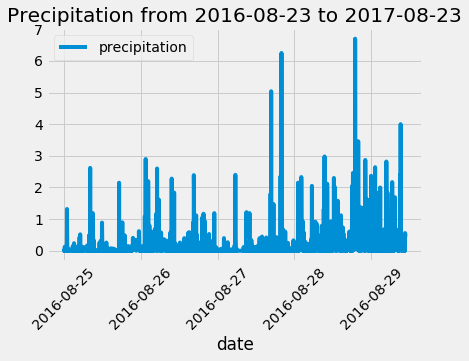

In [73]:
# Plot the precipitation
ax = df.plot()
ax.set_xticklabels(df.index,rotation=45)
ax.set_title("Precipitation from 2016-08-23 to 2017-08-23")
plt.show()

In [74]:
# Print the summary statistics
df.describe()

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


## Station Analysis

In [14]:
# Find out how many total stations there are
num_stations = session.query(Measurement.station).group_by(Measurement.station).all()

print(f"There are {len(num_stations)} stations.")

There are 9 stations.


In [15]:
# Find and print the most active stations
most_active_stations = session.query(Station.name, Station.station, func.count(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.name, Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

most_active_stations

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

By the above query, Waihee has the highest number of observations

In [75]:
# Retrieve the last 12 months of temperature observation data
year_prior = datetime.strptime('2016-08-23', '%Y-%m-%d')

last_12_months = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= year_prior)
    
last_12_months.all()

[('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 77),
 ('USC00519397', 78),
 ('USC00519397', 78),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 81),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 75),
 ('USC00519397', 79),
 ('USC00519397', 76),
 ('USC00519397', 76),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 78),
 ('USC00519397', 76),
 ('USC00519397', 78),
 ('USC00519397', 78),
 ('USC00519397', 75),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 81),
 ('USC00519397', 77),
 ('USC00519397', 77),
 ('USC00519397', 78),
 ('USC00519397', 76),
 ('USC00519397', 82),
 ('USC00519397', 81),
 ('USC00519397', 78),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 79),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC0051

In [76]:
# Find which station had the most observations in that timeframe and filter on that
most_active_stations_last_12_months = session.query(Station.name, Station.station, func.count(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Measurement.date >= year_prior).\
    group_by(Station.name, Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
    
    
most_active_stations_last_12_months

[('WAIKIKI 717.2, HI US', 'USC00519397', 360),
 ('WAIHEE 837.5, HI US', 'USC00519281', 351),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 348),
 ('KANEOHE 838.1, HI US', 'USC00513117', 342),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 336),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 304),
 ('PEARL CITY, HI US', 'USC00517948', 182)]

In [77]:
# Waikiki has the most observations in the past 12 months
# filtering on that yields this data

last_12_months_waikiki = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= year_prior).\
    filter(Measurement.station == 'USC00519397').all()
    
last_12_months_waikiki

[('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 77),
 ('USC00519397', 78),
 ('USC00519397', 78),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 81),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 75),
 ('USC00519397', 79),
 ('USC00519397', 76),
 ('USC00519397', 76),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 78),
 ('USC00519397', 76),
 ('USC00519397', 78),
 ('USC00519397', 78),
 ('USC00519397', 75),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 81),
 ('USC00519397', 77),
 ('USC00519397', 77),
 ('USC00519397', 78),
 ('USC00519397', 76),
 ('USC00519397', 82),
 ('USC00519397', 81),
 ('USC00519397', 78),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC00519397', 79),
 ('USC00519397', 79),
 ('USC00519397', 80),
 ('USC00519397', 80),
 ('USC00519397', 79),
 ('USC0051

In [78]:
tobs = [x[1] for x in last_12_months_waikiki]

In [79]:
tobs_df = pd.DataFrame({'tobs': tobs})

In [80]:
tobs_df

,tobs
0,79
1,80
2,79
3,77
4,78
5,78
6,79
7,80
8,81
9,80


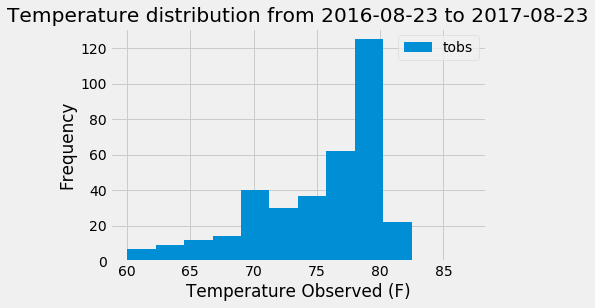

In [81]:
ax = tobs_df.plot.hist(bins = 12)
ax.set_title("Temperature distribution from 2016-08-23 to 2017-08-23")
ax.set_xlabel("Temperature Observed (F)")
plt.show()

## Temperature Analysis

In [82]:
def calc_temps(start_dt, end_dt):
    from datetime import datetime
    
    dt1 = datetime.strptime(start_dt, '%Y-%m-%d')
    dt2 = datetime.strptime(end_dt, '%Y-%m-%d')
    
    data = session.query(Measurement.tobs).\
        filter(Measurement.date >= dt1).\
        filter(Measurement.date <= dt2).all()
        
    data = [x[0] for x in data]
    
    summary = pd.DataFrame({'min': min(data),
                            'max': max(data),
                            'mean': sum(data)/len(data)}, index = [0])
    
    return summary
    

In [83]:
trip_start_dt

'2018-03-01'

In [84]:
trip_end_dt

'2018-03-15'

In [85]:
# Given the above trip dates, define the matched dates
matched_start_dt = '2017-03-01'
matched_end_dt = '2017-03-15'

In [86]:
# Run the function on our matched dates
temp_df = calc_temps(matched_start_dt, matched_end_dt)

In [87]:
temp_df

,max,mean,min
0,82,71.282353,62


(0, 100)

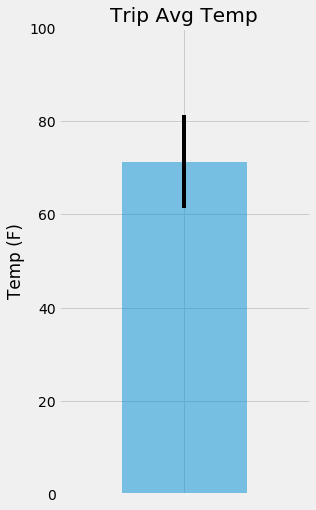

In [88]:
# Since we're using the error as the difference between the max and the min, we need to set that and divide by 2
yerr_line = (temp_df['max']-temp_df['min'])/2

ax = temp_df['mean'].plot.bar(yerr=yerr_line, figsize=(4,8), alpha = 0.5)

# Remove 0 index label and add other labels and stylings
ax.set_xticklabels("")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
ax.set_ylim([0,100])